# quarkml 功能介绍
```
适用于风控算法领域，集 特征处理，特征工程，模型训练， 树模型分布式训练等功能于一体的自动化工具
主要功能：
    1. 特征工程
       a. 特征处理，分类特征转换数值index，空值填充，异常值去除, 数据压缩，特征分析报告打印
       b. 特征衍生，基于内置的算子进行自动衍生，并基于booster方法进行筛选海量衍生特征
       c. 特征选择，对自特征进行筛选【fwiz，iv，psi，tmodel】
    2. 模型工程
       a. 模型交叉验证，用于验证模型性能
       b. 模型超参
       c. 模型训练，提供树模型多进程训练，分布式训练，常规训练
       d. 模型解释性，自动化产生shap 模型解释图
       e. 预估加速，对于常规进行joblib保存的模型进行编译，生成编译文件，然后利用load_model，predict进行预估
    3. 分布式工程
       a. 分布式训练lightgbm
       b. 分布式数据处理
```

## quarkml 包的功能代码演示

### 项目开始导入相关包

In [ ]:
import ray
import pandas as pd
import shap
from quarkml.feature_engineering import FeatureEngineering
from quarkml.model_engineering import ModelEngineering
from quarkml.distributed_engineering import DistributedEngineering

### 创建工具处理类

In [2]:
FE = FeatureEngineering()
ME = ModelEngineering()
DE = DistributedEngineering()

### 功能一，特征处理 使用FE工具的 data_processing_fit 方法
```
1. 划分数据集中的类别特征和数值特征
   其中会根据数据中数值特征的唯一值总量进行判断，若总量小于ordinal_number（可配置参数），会划入类别特征
2. 缺失值填充
   对类别特征的填充采用数据中的众数，对数值特征的填充采用数据中的均值
   会保留每个特征的填充逻辑，方便后续新数据复用
3. 异常值删除
   检测异常的方法一：均方差
   在统计学中，如果一个数据分布近似正态，
   那么大约 68% 的数据值会在均值的一个标准差范围内，
   大约 95% 会在两个标准差范围内，
   大约 99.7% 会在三个标准差范围内。
   这里采用3个标准差以外的进行去除

4. 对离散特征进行数值化，tokenizer
   对每列特征进行转换index, [男， 女] -> [0, 1] 并保留{男: 0, 女: 1}
   会保留每个特征的tokenizer逻辑，方便后续新数据复用

5. 展示数据中的每个 feature-label 分布
   会展示数据的基础信息和基本描述
   会有每个特征与目标的分布，保存图到本地
   会给出整数据的详细分析报告，保存为html形式，可直接打开查看

6. 对数据进行压缩
   对数据中的数值化数据进行分析，判断数据的中最大最小范围，然后对数据采用合理的数据类型【int64-int32-int16-float64-float32-float16】等
```


#### data_processing_fit 介绍
```python
data_processing_fit(
  ds: str | pd.DataFrame,
  label: str,
  cat_feature: List = [],
  num_feature: List = [],
  ordinal_number=100,
  is_fillna=False,
  drop_outliers=False,
  is_token=True,
  verbosity=False,
  compress=False,
  report_dir="./encode",
)
ds: str | pd.DataFrame, 原始数据 （必选项）, 若传入文件路径，则返回处理后的新文件路径（处理后的数据文件）， 若传入DataFrame，则返回新的DataFrame
label: str,  原始数据的label （必选项）
cat_feature: list = [], 指定类别特征， （非选项）， 若为空，则会利用上述【功能1】获得
num_feature: list = [], 指定连续特征， （非选项）， 若为空，则会利用上述【功能1】获得
ordinal_number=100, 指定数值特征若唯一值总数小于ordinal_number，则会划分成类别特征，用于【功能1】， （非选项）， 若为空，默认 100
is_fillna=False, 是否自动缺失值填充【功能2】，连续值填充众数，离散值填充均值
drop_outliers=False, 是否异常值删除【功能3】
is_token=True, 是否数值化【功能4】
verbosity=False, 是否展示分析报告【功能5】
compress=False, 是否对数据进行压缩【功能6】
report_dir="./encode", 上述功能产生的中间结果都会落到该文件夹内
```

In [ ]:
# 数据处理
ds = pd.read_csv("credit.csv")
print("处理前：", ds.head(5))
ds, cat, con = FE.data_processing_fit(ds, 'class')
print("处理后：",ds.head(5))

### 功能二，特征衍生 使用FE工具中 feature_generation 方法
1. 对给予数据进行特征衍生，产生大量的候选特征集
2. 对衍生后的候选特征集进行筛选，获得最终对效果指标有意义的特征集

#### feature_generation 方法介绍
```python
feature_generation(
   ds: str | pd.DataFrame,
   label: str,
   cat_features: List = None,
   is_filter=True,
   params=None,
   select_method='predictive',
   min_candidate_features=200,
   blocks=5,
   ratio=0.5,
   distributed_and_multiprocess=-1,
   report_dir="encode",
)

ds: str | pd.DataFrame, 原始数据 （必选项）, 若传入文件路径，则返回处理后的新文件路径（处理后的数据文件）， 若传入DataFrame，则返回新的DataFrame
label: str,  原始数据的label （必选项）
cat_features: list = None, 指定类别特征， （非选项）， 若为空，则会利用原始数据的非number类型 设置 为cat
is_filter: 是否对衍生后的特征进行筛选，由于衍生的特征数巨大，所以默认为True
params: 特征筛选过程中树模型的参数（非选项）， 若为空，有默认参数
select_method: 筛选的评估指标，predictive -> 提升收益，corr 为与目标的相关度
min_candidate_features: 最小候选特征，若每个block后，候选特征小于最小候选特征，就停止block了
blocks： 主要是用于booster 中对数据进行增量式划分成多个数据块
ratio：主要是用于booster 中candidate_features被淘汰ratio=0.5 一半了就，可以直接全量数据进行淘汰了，数据量越大，该值应该设置越小一般在0.2 ~ 0.5
distributed_and_multiprocess=-1， 三种运行模式【常规 -1，多进程 2，分布式 1】
report_dir="./encode", 中间结果存储
```

In [ ]:
# 特征衍生
ds = FE.feature_generation(ds, 'class', cat, is_filter=True)

### 功能三，特征选择 采用FE 的 feature_selector 方法
1. 对提供的数据集进行计算特征的IV值，并基于IV的过滤条件去掉某些特征， 会产生 IV值表
2. 对提供的数据集进行计算特征的PSI值，并基于PSI的过滤条件去掉某些特征，会产生 PSI值表
3. 对提供的数据集进行计算特征的fwiz值（最大最小相关性），并基于fwiz的过滤条件去掉某些特征
4. 对提供的数据集进行计算特征的重要性（tmodel），并基于特征的重要性去掉某些特征，会产生 model重要性值表

具备4中特征选择方法【fwiz，iv，psi，tmodel】，其中除fwiz 方法外，其他方法均具备三种运行模式【常规，多进程，分布式】
小数据量下运行耗时H比较 H(多进程) < H(常规) < H(分布式)
大数据量下单机无法运行时 - 推荐用分布式

fwiz 基于SULOV（搜索不相关的变量列表），SULOV 注定只能针对连续值，
SULOV算法基于本文中解释的最小冗余最大相关性（MRMR）算法，该算法是最佳特征选择方法之一

iv 风控领域常使用的IV值

psi 风控领域常使用的PSI值

tmodel 基于树模型训练后的特征重要性进行选择，其中有4种特征重要性【importance， permutation， shap， all】
    - importance 为树的划分节点gain值总和
    - permutation 评估特征的随机和非随机的预估值差值比较（模型无关性）
    - shap 类似permutation， 只是更加严格，【具体可学习Shap 值】
    - all 是综合上述三种方法选出的特征交集

#### feature_selector 方法介绍
```python
feature_selector(
ds: str | pd.DataFrame,
label: str,
part_column: str = None,
cate_features: List[str] = None,
part_values: List = None,
bins=10,
importance_metric: str = "importance",
method: str = "fwiz",
distributed_and_multiprocess=-1,
report_dir="encode",
)

ds: str | pd.DataFrame, 原始数据 （必选项）, 若传入文件路径，则返回处理后的新文件路径（处理后的数据文件）， 若传入DataFrame，则返回新的DataFrame
label: str,  原始数据的label （必选项）
cat_features: list = None, 指定类别特征， （非必选项）， 若为空，则会利用原始数据的非number类型 设置 为cat
part_column: str = None,  划分列，主要是用于PSI筛选特征的方法内，表明用这个一列进行划分数据集，然后比较每个数据两两之间的差异，当method为psi 时是必选项
part_values: str = None,  划分列，与part_column 一起用，表明用这个一列按part_values list 内的值进行划分，然后比较每个数据两两之间的差异（非必选项）， 若为空，将去part_column列中的所有值
bins=10,: IV计算中的分桶数
importance_metric: str = 'importance',  tmodel_method方法得到的重要性分为3种方式的 ： importance， permutation， shap
method: str = "booster", 特征筛选的方法：fwiz ， iv ， psi ， tmodel ， 注fwiz-基于SULOV（搜索不相关的变量列表）
distributed_and_multiprocess=-1， 三种运行模式【常规 -1，多进程 2，分布式 1】
report_dir="encode", 特征筛选过程中的一些中间结果存在路径
```

In [ ]:
# 特征选择 tmodel
tmodel = FE.feature_selector(ds, 'class', cate_features=cat,  method='tmodel')

In [ ]:
# 特征选择 iv
iv = FE.feature_selector(ds, 'class', cate_features=cat,  method='iv')

In [ ]:
# 特征选择 psi
psi = FE.feature_selector(ds, 'class', part_column='age', cate_features=cat,  method='psi')

In [ ]:
# 特征选择 fwiz
fwiz = FE.feature_selector(ds, 'class', cate_features=cat,  method='fwiz')

### 功能四，模型自动超参 采用 ME 工具中的 hparams 方法
基于提供的数据进行模型lightgbm，参数寻优，基于贝叶斯超参方式找到最优参数

#### hparams 方法的介绍
``` python
hparams(
   ds: pd.DataFrame,
   label: str,
   valid_ds: pd.DataFrame = None,
   cat_features=None,
   params=None,
   spaces=None,
   report_dir="encode")

ds: str | pd.DataFrame, 原始数据 （必选项）, 可以是DataFrame 或者 文件路径
label: str,  原始数据的label （必选项）
valid_ds: str | pd.DataFrame, 原始验证数据 （非必选项）, 可以是DataFrame 或者 文件路径
cat_features: list = None, 指定类别特征， （非必选项）， 若为空，则会利用原始数据的非number类型 设置 为cat
params=None, lgb模型的参数，非必选项，若没有，会采用系统默认的
spaces=None, 寻参的设置空间， 熟悉hyperopt应该知道怎么配置
report_dir="encode"
```


In [ ]:
# 自动超参
best_params_hyperopt = ME.hparams(ds, 'class', cat_features=cat)

### 功能五，模型交叉验证，寻到模型的上限 采用 ME 工具中 model_cv 方法
基于提供的数据进行lightgbm的交叉验证

#### model_cv 方法介绍
``` python
model_cv(
   ds: pd.DataFrame,
   label: str,
   valid_ds: pd.DataFrame = None,
   categorical_features=None,
   params=None,
   folds=5,
   distributed_and_multiprocess=-1,
)

ds: str | pd.DataFrame, 原始数据 （必选项）, 可以是DataFrame 或者 文件路径
label: str,  原始数据的label （必选项）
valid_ds: str | pd.DataFrame, 原始验证数据 （非必选项）, 可以是DataFrame 或者 文件路径
cat_features: list = None, 指定类别特征， （非必选项）， 若为空，则会利用原始数据的非number类型 设置 为cat
params=None, lgb模型的参数，非必选项，若没有，会采用系统默认的
folds=5,交叉验证的数据划分份数，用于tmodel
distributed_and_multiprocess=-1， 三种运行模式【常规 -1，多进程 2，分布式 1】
```

In [ ]:
# 交叉验证
ME.model_cv(ds, 'class', params=best_params_hyperopt)

### 功能五，lightgbm模型训练， 快速自动化训练, 采用ME工具中的 model 方法
基于提供的数据进行lightgbm的训练

#### model 方法介绍
``` python

model(
   ds: pd.DataFrame,
   label: str,
   valid_ds: pd.DataFrame = None,
   cat_features=None,
   params=None,
   report_dir="encode",
)

ds: str | pd.DataFrame, 原始数据 （必选项）, 可以是DataFrame 或者 文件路径
label: str,  原始数据的label （必选项）
valid_ds: str | pd.DataFrame, 原始验证数据 （非必选项）, 可以是DataFrame 或者 文件路径
cat_features: list = None, 指定类别特征， （非必选项）， 若为空，则会利用原始数据的非number类型 设置 为cat
params=None, lgb模型的参数，非必选项，若没有，会采用系统默认的
report_dir="encode" lgb模型训练保存的路径report_dir下的 loan_model.pkl
```

In [ ]:
cls = ME.model(ds, 'class', params=best_params_hyperopt)

### 功能六，模型解释性 利用 ME中的 init_set_model_x 方法

### init_set_model_x 方法说明
``` python
init_set_model_x(cls, x)
cls 为模型训练后的模型对象
x 为 用于解释的样例
```

In [14]:
x = ds.drop('class', axis=1)
shap_values = ME.FI.init_set_model_x(cls[0], x)

#### 模型可解释性-单样本中特征对label的影响

In [15]:
# 模型可解释性-单样本中特征对label的影响
shap.plots.force(shap_values[0])

上图说明，红色是对预估值正向，蓝色是对预估值负向， 其中0.9为预估值，下面是每个特征的shap值，如 autoFE_f_3=24表示autoFE_f_3的shap值为24 ，对预估值0.9是正向影响

### 模型可解释性-多样本中特征对label的影响

In [16]:
# 模型可解释性-多样本中特征对label的影响
shap.plots.force(shap_values[:50])

#### 模型可解释性-单样本中特征对label的影响

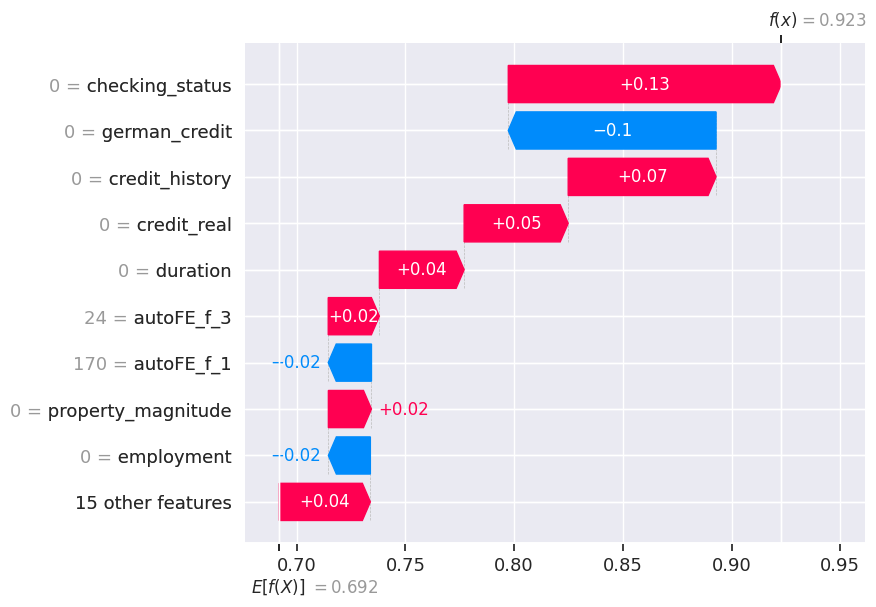

In [17]:
# 模型可解释性-单样本中特征对label的影响
shap.plots.waterfall(shap_values[0])

#### 模型可解释性-多样本中特征对label的影响

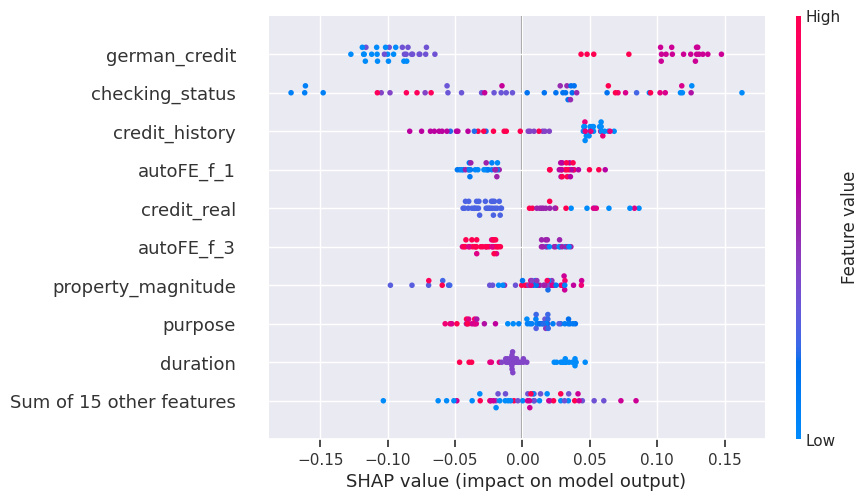

In [18]:
# 模型可解释性-多样本中特征对label的影响
shap.plots.beeswarm(shap_values[:50])

#### 模型可解释性-特征重要性

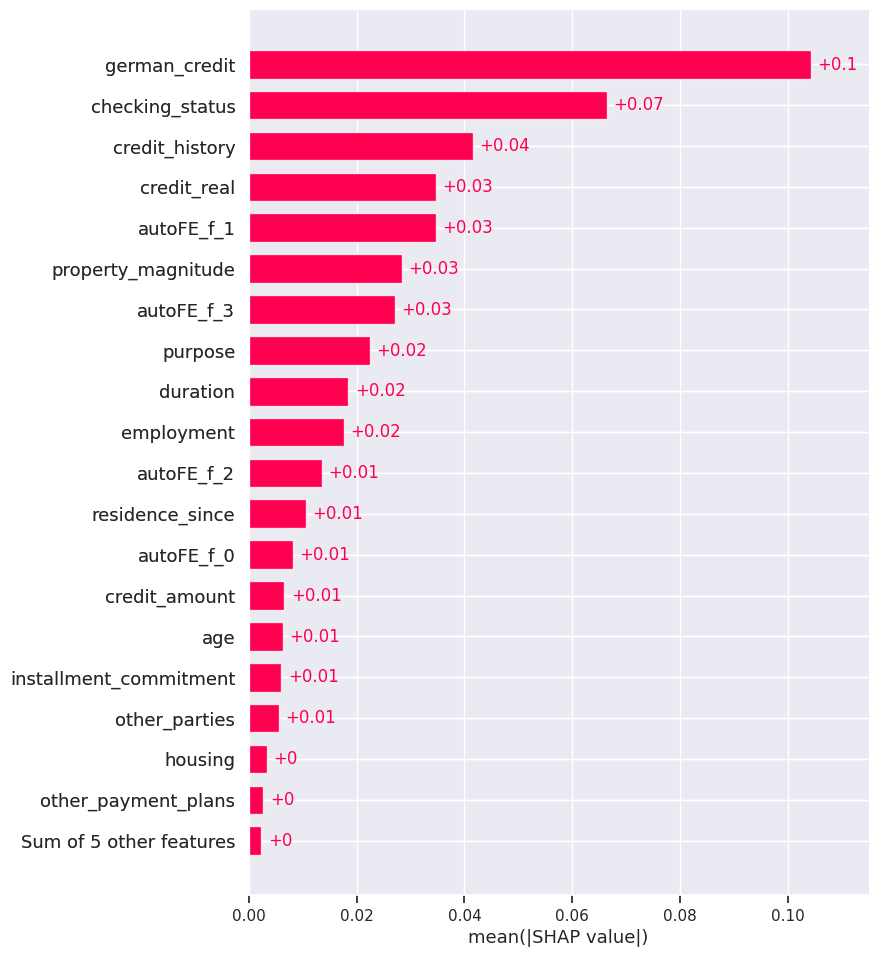

In [19]:
# 模型可解释性-特征重要性
shap.plots.bar(shap_values, max_display=20)